These notes follow "The Metropolis-Hastings algorithm" (C.P. Robert, 2016).

Monte Carlo methods encompass a large family of sampling-based numerical integration techniques.

Several of these are based on Markov chain theory. These are Markov chain Monte Carlo (MCMC) techniques. One such variant is the Metropolis-Hastings algorithm.



Consider a state space $\mathcal{X}$ upon which a probability density $\pi$ is defined. Assume that $\pi$ is computable up to a multiplicative constant, i.e., $$ \pi\left(x\right) \propto \tilde{\pi}\left(x\right) $$
Metropolis-Hastings is a method for constructing an ergodic Markov chain on $\mathcal{X}$ which is stationary with respect to $\pi$: $$ X^{\left(t\right)} \sim \pi \left(x\right) \; \implies \; X^{\left(t+1\right)} \sim \pi \left(x\right) $$ It follows that this Markov chain converges (in distribution) to $\pi$.

Why do we need such a method? 
> "They provide shortcuts in cases where generic sampling requires too much effort from the experimenter."

This refers to a simple approach such as grid sampling, which suffers from the so-called "curse of dimensionality."

We start with the target density $\pi$ which we want to find. We must choose a conditional proposal density $q$ such that the transition from the Markov chain value $X^{\left(t\right)}$ to $X^{\left(t+1\right)}$ is governed by the steps

1. Generate $Y_t \sim q\left(y\,\middle|\,x^{\left(t\right)}\right)$
2. Assign $$ X^{\left(t+1\right)} = \left\{ \begin{array}{lc} Y_t & \text{with probability} \; p\left(x^{\left(t\right)},Y_t\right) \\ x^{\left(t\right)} &  \text{with probability} \; 1-p\left(x^{\left(t\right)},Y_t\right) \end{array}\right. $$

The proposal density $q$ is where the $Y_t$ value comes from, which is used both to make the decision and also may be the next value $X^{\left(t+1\right)}$. The distribution $q$ of $y$ is conditional on the current value $X^{\left(t\right)}$, which is where the notion of Markov chain comes from. The probability in the decision is defined as $$ p\left(x,y\right) = \min \left\{ \frac{\tilde{\pi}\left(y\right)}{\tilde{\pi}\left(x\right)} \frac{q\left(x\,\middle|\,y\right)}{q\left(y\,\middle|\,x\right)}, 1\right\} $$

In the original paper, by Metropolis (1953), this transition update step preserves the stationary density $\pi$ if the chain is irreducible (i.e., if $q$ has wide enough support so that we can reach any region of $\mathcal{X}$ with positive mass under $\pi$). This is particularly interesting since we started with an arbitrary choice of density $q$ and this update preserves $\pi$ as the stationary distribution. In pratice, we must choose $q$ wisely to ensure feasible convergence. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import normal, uniform

In [200]:
# target: mult const perturbed normal
def target(x): 
    return (np.sin(x)**2) * (np.sin(2*x)**2) * np.exp(-0.5*(x**2))

def metropolis_step(x, alpha=1):
    y = uniform(x-alpha, x+alpha, size=1) # kernel is used here
    z = uniform(0,1,1)
    if np.log(z) < np.log(target(y)) - np.log(target(x)):
        return y
    else:
        return x



In [201]:
x = np.pi
y = uniform(x-1,x+1,1)
print("x = ",x)
print("y = ",y[0])
print("target(x) = ", target(x))
print("target(y) = ", target(y)[0])

x =  3.141592653589793
y =  3.6589437609502213
target(x) =  6.470622048153808e-66
target(y) =  0.00022389160130408553


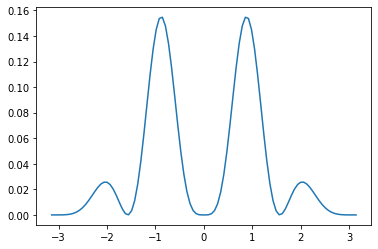

In [202]:
t = np.linspace(-np.pi, np.pi, num=100)
plt.plot(t,pi_tilde(t))

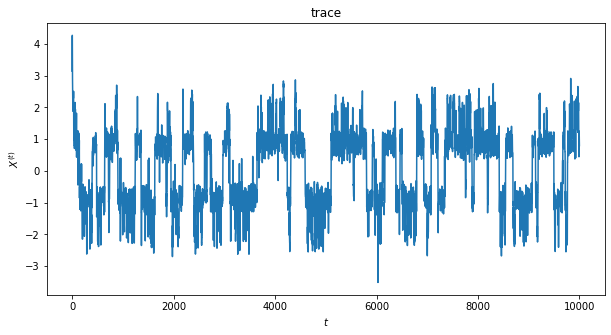

In [215]:
trace = np.repeat(np.pi-0.01, 10**4)
trace[0] = np.pi
for j in range(1,len(trace)):
    trace[j] = metropolis_step(trace[j-1])

plt.figure(figsize=(10,5))
plt.plot(trace[:])
plt.title("trace")
plt.xlabel(r"$t$")
plt.ylabel(r"$X^{\left(t\right)}$")
plt.show()

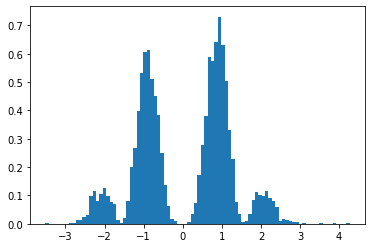

In [218]:
plt.hist(trace,bins=90, density=True);

Now, if we adjust the $\alpha$ parameter, which controls the width of the kernel, we can control how likely we are to move around in the space. For instance, if we shrink $\alpha$, then we are limiting the extent of the uniform distribution from which we draw $Y_t$, which, recall, is our candidate for the next state value $X^{\left(t+1\right)}$.

As we make $\alpha$ smaller, we see that the trace is more likely to stay closer to one or only a few of the peaks (modes) in the distribution.

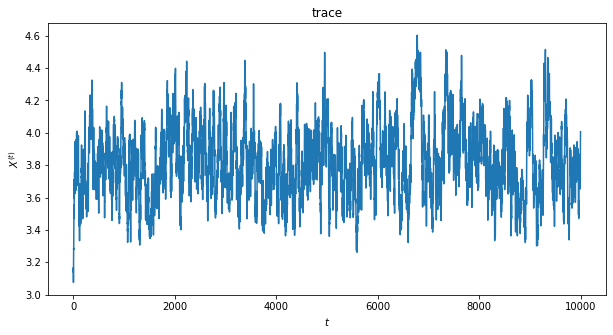

In [228]:
trace = np.repeat(np.pi-0.01, 10**4)
trace[0] = np.pi
for j in range(1,len(trace)):
    trace[j] = metropolis_step(trace[j-1], alpha=0.1)

plt.figure(figsize=(10,5))
plt.plot(trace[:])
plt.title("trace")
plt.xlabel(r"$t$")
plt.ylabel(r"$X^{\left(t\right)}$")
plt.show()

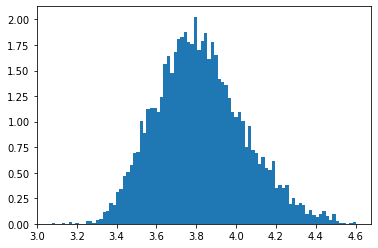

In [229]:
plt.hist(trace,bins=90, density=True);

The next example samples from a bivariate normal distribution.

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import normal, uniform
from numpy.random import multivariate_normal
import scipy.stats as sps

def target(x):
    """ x is a 2-vector """
    return sps.multivariate_normal.pdf([x[0],x[1]], mean=[5,5], cov=[[1,.9],[.9,1]])

def metropolis_step(x, alpha=1):
    # y = uniform(x-alpha, x+alpha, size=1) # kernel is used here
    # use a multivariate normal kernel about x to sample from
    y = multivariate_normal(mean=x, cov=[[1.,0.],[0.,1.]])
    z = uniform(0,1,1)
    if np.log(z) < np.log(target(y)) - np.log(target(x)):
        return y
    else:
        return x


n = 10**4
trace = np.zeros((n,2))
trace[0,:] = [1.,0.]
for j in range(1,trace.shape[0]):
    trace[j] = metropolis_step(trace[j-1], alpha=0.1)

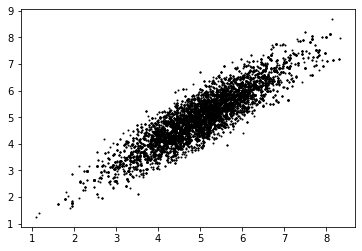

In [4]:
fig, ax = plt.subplots()
for j in range(200,trace.shape[0]):
    ax.scatter(trace[j,0], trace[j,1], c='k', marker='.', s=4)

# Change-point Model

Let's try a harder example. This is the change-point problem explored in the Gibbs sampling notes. In this situation, we have a discrete parameter, $n$, the change-point index parameter. Since the Metropolis-Hastings algorithm picks its next iteration value through use of a kernel (proposition) distribution, I am using a bivariate Gaussian (a symmetric distribution) about the current iteration value. I don't know quite how to extend this to discrete variables. For now, I will treat the change-point as a given and just find posteriors over the $\lambda$ parameters.

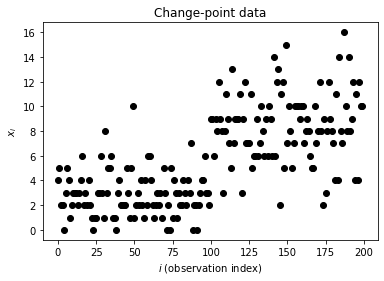

In [123]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import normal, uniform, poisson
import scipy.stats as sps

N = 200 # total observations
t = np.arange(start=0,stop=N) # observation times

# exact parameters
lam1 = 3
lam2 = 8.5
n = 100

# generate data
x = np.concatenate([poisson(lam=lam1, size=n),poisson(lam=lam2, size=(N-n))])

fig, ax = plt.subplots()
ax.scatter(t,x, color='k', marker='o')
ax.set_title("Change-point data")
ax.set_xlabel(r"$i$ (observation index)")
ax.set_ylabel(r"$x_i$ ")
plt.show()

In [131]:
x_sum_n = np.sum(x[0:n])
x_sum_N = np.sum(x[n:])

def log_target(theta):
    """ theta = (lambda_1, lambda_2) are the parameter space
        The data x is assumed given here
    """
    lambda_1, lambda_2 = theta

    # log_prob = -2 * (lambda_1+lambda_2) + np.log(lambda_1) +np.log(lambda_2) \
    #     + np.log(lambda_1) * np.sum(x[0:n]) \
    #         + np.log(lambda_2) * np.sum(x[n:])

    log_prob = (x_sum_n + 1) * np.log(lambda_1) + (x_sum_N + 1 )* np.log(lambda_2) \
        - (n+1)*lambda_1 - (len(x)-n+1)*lambda_2
    # print(log_prob)
    return log_prob


def metropolis_step(theta, alpha=1):
    # use a multivariate normal kernel about x to sample from
    # recall we are sampling from theta-space
    y = multivariate_normal(mean=theta, cov=[[1.,0.],[0.,1.]])
    z = uniform(0,1,1)
    # print("y ", y)
    # print("z ", z)
    # print("target(y) ", log_target(y))
    # if np.log(z) < np.log(target(y)) - np.log(target(theta)):
    if np.log(z) < log_target(y) - log_target(theta):
        return y
    else:
        return theta


n_iter = 10**4
burn_in = 10**3
trace = np.zeros((n_iter,2))
trace[0,:] = [5.,5.]
for j in range(1,n_iter):
    trace[j] = metropolis_step(trace[j-1])

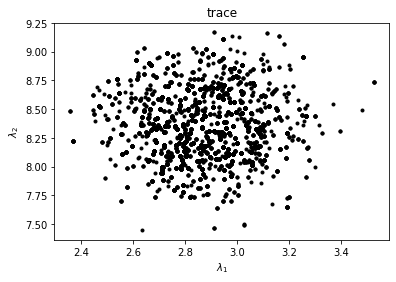

In [137]:
plt.scatter(trace[burn_in::2,0], trace[burn_in::2,1], c='k', marker='.')
plt.xlabel(r'$\lambda_1$')
plt.ylabel(r'$\lambda_2$')
plt.title("trace")
plt.show()

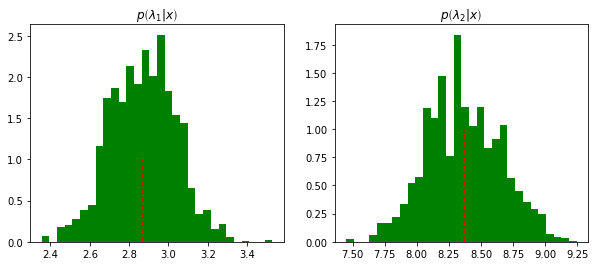

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
est = np.mean(trace[burn_in:,:], axis=0)

ax[0].hist(trace[burn_in:,0], bins=30, color='g', density=True)
ax[0].set_title(r"$p\left(\lambda_1|x\right)$")
ax[0].vlines(x=est[0], ymin=0, ymax=1, color='r', ls='--')
ax[1].hist(trace[burn_in:,1], bins=30, color='g', density=True)
ax[1].set_title(r"$p\left(\lambda_2|x\right)$")
ax[1].vlines(x=est[1], ymin=0, ymax=1, color='r', ls='--')
plt.show()

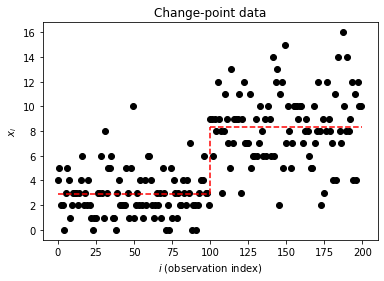

In [139]:
# print(est)

fig, ax = plt.subplots()
ax.scatter(t,x, color='k', marker='o')
ax.hlines(y=est[0], xmin=0,xmax=n, color='r', ls='--')
ax.hlines(y=est[1], xmin=n,xmax=len(x), color='r', ls='--')
ax.vlines(x=n, ymin=est[0],ymax=est[1], color='r', ls='--')

ax.set_title("Change-point data")
ax.set_xlabel(r"$i$ (observation index)")
ax.set_ylabel(r"$x_i$ ")
plt.show()

Idea: it may be possible to pick the next values for $n$ by using a discrete distribution centered about the current value of $n$. That is, given a value of $n^{\left(t\right)}$, pick a candidate value for $n^{\left(t+1\right)}$, say $y_n$, by sampling from the distribution $\text{Cat}\left\{n-2,n-1,n,n+1,n+2\right\}$ or something similar. The $\lambda$s can be sampled as before. This is just our choice of a kernel.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from numpy.random import normal, uniform, poisson
import scipy.stats as sps

N = 200 # total observations
t = np.arange(start=0,stop=N) # observation times

# exact parameters
lam1 = 3
lam2 = 8.5
n = 100

# generate data
x = np.concatenate([poisson(lam=lam1, size=n),poisson(lam=lam2, size=(N-n))])

fig, ax = plt.subplots()
ax.scatter(t,x, color='k', marker='o')
ax.set_title("Change-point data")
ax.set_xlabel(r"$i$ (observation index)")
ax.set_ylabel(r"$x_i$ ")
plt.show()

In [183]:
def log_target(theta):
    """ theta = (lambda_1, lambda_2, n) are the parameter space
        The data x is assumed given here
    """
    lambda_1, lambda_2 = theta[0:2]
    n = int(theta[2])

    x_sum_n = np.sum(x[0:n])
    x_sum_N = np.sum(x[n:])

    log_prob = (x_sum_n + 1) * np.log(lambda_1) + (x_sum_N + 1 )* np.log(lambda_2) \
        - (n+1)*lambda_1 - (len(x)-n+1)*lambda_2
    # print(log_prob)
    return log_prob


def metropolis_step(theta, alpha=1):
    # use a multivariate normal kernel about x to sample from
    # recall we are sampling from theta-space
    y = np.concatenate((multivariate_normal(mean=theta[:2], cov=[[1.,0.],[0.,1.]]), np.array([np.random.randint(low=n-2, high=n+2)])), axis=0)
    # print(y)
    z = uniform(0,1,1)
    # print("y ", y)
    # print("z ", z)
    # print("target(y) ", log_target(y))
    # if np.log(z) < np.log(target(y)) - np.log(target(theta)):
    if np.log(z) < log_target(y) - log_target(theta):
        return y
    else:
        return theta


n_iter = 10**4
burn_in = 10**3
trace = np.zeros((n_iter,3))
trace[0,:] = [5.,5., 75]
for j in range(1,n_iter):
    # print(j)
    trace[j] = metropolis_step(trace[j-1])

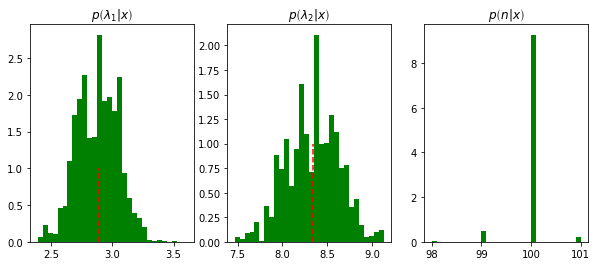

In [186]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
est = np.mean(trace[burn_in:,:], axis=0)

ax[0].hist(trace[burn_in:,0], bins=30, color='g', density=True)
ax[0].set_title(r"$p\left(\lambda_1|x\right)$")
ax[0].vlines(x=est[0], ymin=0, ymax=1, color='r', ls='--')
ax[1].hist(trace[burn_in:,1], bins=30, color='g', density=True)
ax[1].set_title(r"$p\left(\lambda_2|x\right)$")
ax[1].vlines(x=est[1], ymin=0, ymax=1, color='r', ls='--')
ax[2].hist(trace[burn_in:,2], bins=30, color='g', density=True)
ax[2].set_title(r"$p\left(n|x\right)$")
# ax[2].vlines(x=est[2], ymin=0, ymax=1, color='r', ls='--')
plt.show()

# Two-component Gaussian Mixture Model



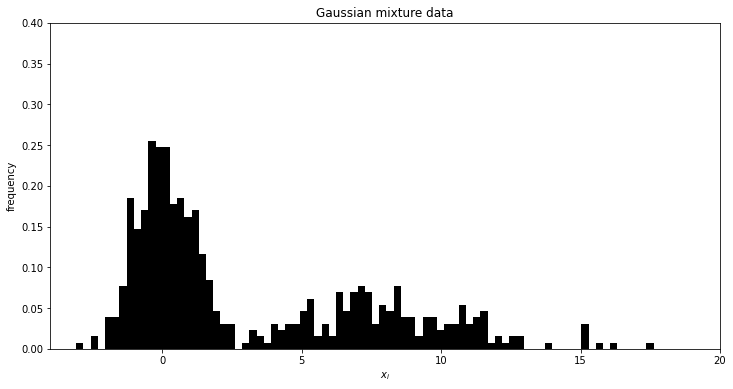

In [236]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.random import binomial, normal

mu_exact = [0, 8]
sig_exact = [1, 3]
pi = 0.4 
n = 500

X = np.empty(shape=(n,2)) # x,z
for i in range(n):
    # get the component
    k = binomial(1, pi, 1)
    # sample from this component
    if k==0:
        X[i,:] = [normal(loc=mu_exact[0], scale=sig_exact[0], size=1), k]
    else:
        X[i,:] = [normal(loc=mu_exact[1], scale=sig_exact[1], size=1), k]
    
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(X[:,0], bins=80, color='k', density=True)
ax.set_xlim([-4,20])
ax.set_ylim([0,.4])
ax.set_title("Gaussian mixture data")
ax.set_xlabel(r"$x_i$")
ax.set_ylabel("frequency")

plt.show()

In [247]:
def log_target(theta):
    """ theta = (mu_1,mu_2,sig_1,sig_2,pi,z) are the parameter space
        The data x is assumed given here
    """
    mu_1, mu_2, sig_1, sig_2, pi = theta[:5]
    z = theta[5:]

    n_1 = np.sum(z==0.) # first component
    n_2 = np.sum(z==1.)

    log_prob = n_1 * np.log(pi) + n_2 * np.log(1-pi) \
        - 0.5*(mu_1 + mu_2) - 2 * np.log(sig_1) - 2*np.log(sig_2) \
            - (1/sig_1 + 1/sig_2) \
                + np.sum( z==0 * -(X[:,0]-mu_1)**2 / (2*sig_1) - 0.5*np.log(sig_1) ) \
                    + np.sum( z==1 * -(X[:,0]-mu_2)**2 / (2*sig_2) - 0.5*np.log(sig_2) )
    
    return log_prob


def metropolis_step(theta, alpha=1):
    # Sample from the local parameter space
    y = np.zeros_like(theta)

    pi_cur = theta[4]

    y[0:2] = normal(0,.1,size=2) # mu_1, mu_2
    y[2:4] = normal(0,.1,size=2) # sigma_1, sigma_2
    y[4] = normal(0, 0.05, size=1) # pi
    y[5:] = binomial(1, pi_cur, size=X.shape[0])
    # print(y[:10])
    decision = uniform(0,1,1)
    if np.log(decision) < log_target(y) - log_target(theta):
        print("updated theta")
        return y
    else:
        return theta


n_iter = 10**3
burn_in = 10**1
trace = np.zeros((n_iter,5+X.shape[0]))
trace[0,:] = np.concatenate((np.array([4.,4., 1.,1., 0.5,]), binomial(1,0.5,size=X.shape[0])), axis=0)
for j in range(1,n_iter):
    # print(j)
    trace[j] = metropolis_step(trace[j-1])

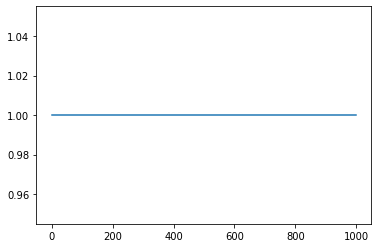

In [243]:
plt.plot(trace[:,2])

In [245]:
trace[:7]

array([[4., 4., 1., ..., 0., 0., 1.],
       [4., 4., 1., ..., 0., 0., 1.],
       [4., 4., 1., ..., 0., 0., 1.],
       ...,
       [4., 4., 1., ..., 0., 0., 1.],
       [4., 4., 1., ..., 0., 0., 1.],
       [4., 4., 1., ..., 0., 0., 1.]])

# Questions to answer
* What exactly is this algorithm for? It says it is for numerical integration, but it looks like we simply are sampling from a particular distribution, which we already know (apart from the normalization constant). How does this help us?
* This seems far too straightforward to be useful. In comparison, Gibbs sampling requires a large amount of analytical preparation in devising the update equations. Why would we use one over the other?
* A difficulty in practice seems to be calibration (determining the hyperparameters such as $\alpha$).
* What is HMC? It is a physics-based alternative which uses a momentum notion to allow the chain to reach distant regions, thus preventing the chain (in part?) from performing too locally, as the Metropolis-Hastings approach, above, did.